In [65]:
import pandas as pd
import numpy as np
import torch
import os
import sys
from tqdm import tqdm, trange

sys.path.append("../../")
import biked_commons
from biked_commons.design_evaluation.design_evaluation import *
from biked_commons.resource_utils import split_datasets_path
from biked_commons.conditioning import conditioning
from biked_commons.design_evaluation.scoring import *
from biked_commons.benchmark_models import generative_modeling_utils, benchmarking_utils


In [66]:
import importlib
importlib.reload(generative_modeling_utils)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = pd.read_csv(split_datasets_path("bike_bench.csv"), index_col=0)

data_tens = torch.tensor(data.values, dtype=torch.float32, device=device)

scaler = generative_modeling_utils.TorchScaler(data_tens)

scaled_data_tens = scaler.scale(data_tens)

continuous_conditioning = generative_modeling_utils.sample_continuous(len(scaled_data_tens))


In [ ]:
importlib.reload(generative_modeling_utils)


def predict(cond_test, generate_fn, batch_size, D, G, noise_dim):
    cond_test = cond_test.to(device)
    predictions = []
    #use batch size
    for i in range(0, len(cond_test), batch_size):
        batch = cond_test[i:i + batch_size]
        pred = generate_fn(D, G, batch, noise_dim, device=device)
        pred = scaler.unscale(pred)
        predictions.append(pred)
    predictions = torch.concat(predictions, axis=0)
    return predictions



def train_and_score(model="VAE", cond_idx=None):

    div_weight_dict = {
        "VAE": 1.0,
        "GAN": 1.0,
        "DDPM_guided": 10000,
        "DDPM_conditional": 1.0,
    }

    div_weight = div_weight_dict[model]
    aux_fn = generative_modeling_utils.get_diversity_loss_fn(scaler, data.columns, 
                                                         diversity_weight = div_weight, 
                                                         score_weight = 1.0, 
                                                         constraint_vs_objective_weight = 10, 
                                                         constraint_falloff = 10, 
                                                         dpp_batch = 16, 
                                                         device = device)

    noise_dim = 10
    batch_size = 512
    epochs = 100 if model != "DDPM_guided" else 1000 # Guided DDPM is fast to train, slower in inference
    train_params = (batch_size, 0.002, 0.002, noise_dim, epochs, 2, 256)
    D, G, generate_fn = generative_modeling_utils.train_model(scaled_data_tens, model, train_params, aux_fn, cond_idx, device)

    if cond_idx is None:
        continuous_condition = generative_modeling_utils.sample_continuous(10000, split="test", randomize=False)
        predictions = predict(continuous_condition, generate_fn, batch_size, D, G, noise_dim).detach()
        main_scores, detailed_scores = benchmarking_utils.evaluate_cond(predictions, f"{model}-PA", data.columns, device=device)
    else:
        continuous_condition = generative_modeling_utils.sample_continuous(10, split="test", randomize=False).to(device)[cond_idx]
        continuous_condition = continuous_condition.repeat(1000, 1)
        predictions = predict(continuous_condition, generate_fn, batch_size, D, G, noise_dim).detach()
        main_scores, detailed_scores = benchmarking_utils.evaluate_uncond(predictions, f"{model}-PA", cond_idx, data.columns, device=device)
        
        
    return main_scores, detailed_scores, predictions


In [78]:
for model in ["DDPM_guided"]:
    main_scores, detailed_scores, predictions = train_and_score(model = model, cond_idx=None)

print("Main scores: ", main_scores)
print("Detailed scores: ", detailed_scores)

c:\Users\Lyle\Documents\Files\DeCoDE\biked-commons\src\biked_commons\benchmark_models\../..\biked_commons\benchmark_models\generative_modeling_utils.py:569: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).float()
100%|██████████| 8/8 [00:01<00:00,  6.96it/s, loss=0.8746]
586it [02:41,  3.62it/s]  


KeyboardInterrupt: 

In [ ]:
DDPM_generate_guided(None, None, None, None, None, None, None)

x requires grad: True
t_embedded requires grad: False
x_input requires grad: True


NameError: name 'numgen' is not defined

In [ ]:
for i in range(10):
    for model in ["VAE", "GAN"]:
        main_scores, detailed_scores, predictions = train_and_score(model = model, cond_idx=i)

print("Main scores: ", main_scores)
print("Detailed scores: ", detailed_scores)

/home/mileva/mambaforge/envs/torch/lib/python3.12/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/mileva/Documents/Lyle/biked-commons/src/biked_commons/benchmark_models/../../biked_commons/benchmark_models/generative_modeling_utils.py:565: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).float()
  2%|▏         | 20/879 [00:05<03:33,  4.03it/s, L_KL=0.5015, L_R=1.2789, L_tot=8.6164, L_aux=7.2372, CSR=0.8555, MCS=3.3939]   

In [ ]:
from biked_commons.design_evaluation import scoring 
from biked_commons.design_evaluation import design_evaluation
importlib.reload(design_evaluation)
importlib.reload(scoring)
evaluator, requirement_names, requirement_types = construct_tensor_evaluator(get_standard_evaluations(device), data.columns)

In [ ]:

weights = scoring.get_ref_point(evaluator, requirement_names, requirement_names, reduction="meanabs")
weights = torch.tensor(weights, dtype=torch.float32, device=device)


In [ ]:
importlib.reload(one_hot_encoding)
preds_df = pd.DataFrame(predictions.cpu().numpy(), columns=data.columns)
# preds_df["SEATSTAYbrdgCheck"] = np.zeros(preds_df.shape[0])
# preds_df["CHAINSTAYbrdgCheck"] = np.zeros(preds_df.shape[0])
# preds_df["MATERIAL OHCLASS: STEEL"] = np.ones(preds_df.shape[0])
# preds_df["MATERIAL OHCLASS: TITANIUM"] = np.zeros(preds_df.shape[0])
# preds_df["MATERIAL OHCLASS: ALUMINUM"] = np.zeros(preds_df.shape[0])
preds_categorical = one_hot_encoding.decode_to_mixed(preds_df)

preds_recont = one_hot_encoding.encode_to_continuous(preds_categorical)
preds_recont_tens = torch.tensor(preds_recont.values, dtype=torch.float32, device=device)

In [ ]:
# diff = preds_recont - preds_df
preds_recont.iloc[:, 60:70]

,Down tube diameter,Seatpost LENGTH,MATERIAL OHCLASS: ALUMINIUM,MATERIAL OHCLASS: BAMBOO,MATERIAL OHCLASS: CARBON,MATERIAL OHCLASS: OTHER,MATERIAL OHCLASS: STEEL,MATERIAL OHCLASS: TITANIUM,Dropout spacing style OHCLASS: 0,Dropout spacing style OHCLASS: 1
0,-1440.109741,-34781.242188,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,650.485657,-6499.270996,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,902.897827,14251.077148,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-2174.821045,40067.628906,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,27.022079,3798.238770,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,2438.705078,16081.666992,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9996,2436.281006,-4168.884766,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,163.987885,958.358887,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9998,2702.572998,-14229.880859,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
preds_df.iloc[:, 60:70]

,Down tube diameter,Seatpost LENGTH,MATERIAL OHCLASS: ALUMINIUM,MATERIAL OHCLASS: BAMBOO,MATERIAL OHCLASS: CARBON,MATERIAL OHCLASS: OTHER,MATERIAL OHCLASS: STEEL,MATERIAL OHCLASS: TITANIUM,Dropout spacing style OHCLASS: 0,Dropout spacing style OHCLASS: 1
0,-1440.109741,-34781.242188,-117.628082,-48.666248,-8.795312,-30.457603,71.179420,4.041924,-44.812244,-116.251617
1,650.485657,-6499.270996,-67.277374,-33.463963,97.195312,-3.640000,-73.414619,-11.301560,77.361969,75.234070
2,902.897827,14251.077148,-126.490646,69.923996,64.389259,-37.321579,-69.730988,-7.926547,-0.822333,188.968292
3,-2174.821045,40067.628906,-31.340334,-22.711889,138.395874,-17.427277,18.648829,-29.361103,-154.962784,37.804203
4,27.022079,3798.238770,78.375481,-8.124111,-10.210581,-66.765007,-60.799885,97.800819,42.667747,-143.484177
...,...,...,...,...,...,...,...,...,...,...
9995,2438.705078,16081.666992,-37.214684,-5.460052,96.960777,-7.482584,-128.274429,-21.250399,-80.266800,15.130573
9996,2436.281006,-4168.884766,-75.126137,9.555010,-73.526047,-25.380285,-49.806866,-16.711887,-13.088316,-157.768646
9997,163.987885,958.358887,17.423084,36.229473,52.156868,-6.478542,-116.237167,-20.894737,35.616623,-4.862740
9998,2702.572998,-14229.880859,56.670563,49.771484,70.864098,-34.574959,19.389462,86.004204,185.479172,-51.379440


In [ ]:
preds_recont_tens

tensor([[ 1.1528e+04,  1.0093e+04,  4.5784e+03,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [-8.4670e+03, -2.4165e+03, -9.5219e+02,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 1.4941e+04,  9.2494e+03,  1.0669e+04,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        ...,
        [ 2.1412e+04, -1.7324e+04, -1.6646e+04,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [-3.4302e+04,  9.0054e+03,  1.0383e+04,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [-2.4559e+04, -6.7875e+03,  1.0262e+04,  ...,  1.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')

In [ ]:
print(evaluator(predictions, condition))
print(evaluator(preds_recont_tens, condition))

tensor([[ 0.0000e+00,  1.7714e+02,  0.0000e+00,  ...,  3.9654e+03,
          1.2569e+05, -5.0000e-01],
        [ 1.0000e+00,  6.8626e+00,  0.0000e+00,  ..., -7.2184e+02,
          7.5619e+04, -5.0000e-01],
        [ 0.0000e+00,  2.4196e+02,  0.0000e+00,  ...,  1.1037e+04,
          7.4165e+04, -5.0000e-01],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.8549e+04,
          1.9285e+05, -5.0000e-01],
        [ 1.0000e+00,  3.7612e+02,  8.7642e-01,  ..., -5.2500e+03,
          6.0428e+04, -5.0000e-01],
        [ 1.0000e+00,  1.3519e+02,  0.0000e+00,  ..., -1.5787e+04,
          1.0643e+05, -5.0000e-01]], device='cuda:0', grad_fn=<CopySlices>)
tensor([[ 0.0000e+00,  1.7714e+02,  0.0000e+00,  ...,  3.9654e+03,
          1.2569e+05, -5.0000e-01],
        [ 1.0000e+00,  6.9514e+00,  0.0000e+00,  ..., -7.2184e+02,
          7.5619e+04, -5.0000e-01],
        [ 0.0000e+00,  2.4196e+02,  0.0000e+00,  ...,  1.1037e+04,
          7.4165e+04, -5.0000e-01],
        ...,
       

In [ ]:
scores = evaluator(preds_recont_tens, condition)
scaled_scores = scores / weights
score_df = pd.DataFrame(scaled_scores.detach().cpu().numpy(), columns=requirement_names)

In [ ]:
torch.sum(torch.all(scaled_scores.detach().cpu()[:, 10:]<=0, axis=1))

tensor(0)

In [ ]:
score_df.iloc[:, 10:]

,Planar Safety Factor,Eccentric Safety Factor,Saddle height too small,Seat post too short,Head tube lower extension too great,Head tube length too great,Certain parameters must be positive,Chain stay should be greater than wheel radius,Chain stay should be greater than BB,Seat stay should be greater than wheel radius,Down tube must reach head tube,The pedal shouldn't intersect the front wheel,The crank shouldn't hit the ground when it is in its lower position,RGB value should be less than 255,Predicted Frame Validity
0,-4.449747,-433.802368,96.012001,142.724457,176.885178,265.726074,239963.796875,-64.086143,-3.915057,-201.701950,18.484221,-216.795334,35.075264,311.081757,-1.00246
1,-87.294235,-156.192719,-78.554482,115.051750,-93.956276,-126.370193,148938.421875,85.118111,16.496664,-167.096329,-27.170889,-118.364395,-6.384863,187.150894,-1.00246
2,1.683600,2.295361,258.877014,-331.361481,-38.038834,-44.690201,219887.078125,-202.910583,-15.517985,-240.110245,-59.944286,-364.457733,97.621971,183.552353,-1.00246
3,-74.457726,-483.894623,-333.818085,40.046333,105.110909,188.985809,107631.914062,-175.860825,-39.995747,-101.016968,56.452396,-224.788376,-1.310979,311.243469,-1.00246
4,1.683600,-17.050131,-509.540558,441.303772,-138.521622,-305.637817,256191.515625,582.511047,169.859406,-670.946777,82.471237,-232.629517,132.190598,240.836182,-1.00246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-4.459352,2.295361,16.483847,-121.618050,-132.148483,-171.382080,159517.687500,-345.193787,-47.831440,-234.262115,-178.853928,-589.713806,95.475380,263.506592,-1.00246
9996,1.683600,2.295361,-64.628937,86.858124,49.253899,75.171082,86471.656250,-35.360283,-31.144684,-99.875099,-121.516983,-102.659615,-73.994972,246.659515,-1.00246
9997,-186.619751,-273.982483,-75.926445,63.214024,-79.010674,-70.971596,265995.531250,-245.296173,-105.611565,-173.575928,37.455105,-369.276520,-164.071808,477.286499,-1.00246
9998,-62.674355,-211.296173,60.138199,39.339397,-173.647476,-196.589127,227060.625000,597.239014,118.075256,-273.042206,-46.572334,-92.195976,-46.437607,149.554916,-1.00246


In [ ]:
score_df.iloc[:, 10:]

,Planar Safety Factor,Eccentric Safety Factor,Saddle height too small,Seat post too short,Head tube lower extension too great,Head tube length too great,Certain parameters must be positive,Chain stay should be greater than wheel radius,Chain stay should be greater than BB,Seat stay should be greater than wheel radius,Down tube must reach head tube,The pedal shouldn't intersect the front wheel,The crank shouldn't hit the ground when it is in its lower position,RGB value should be less than 255,Predicted Frame Validity
0,-4.449747,-433.802368,96.012001,142.724457,176.885178,265.726074,239963.796875,-64.086143,-3.915057,-201.701950,18.484221,-216.795334,35.075264,311.081757,-1.00246
1,-87.294235,-156.192719,-78.554482,115.051750,-93.956276,-126.370193,148938.421875,85.118111,16.496664,-167.096329,-27.170889,-118.364395,-6.384863,187.150894,-1.00246
2,1.683600,2.295361,258.877014,-331.361481,-38.038834,-44.690201,219887.078125,-202.910583,-15.517985,-240.110245,-59.944286,-364.457733,97.621971,183.552353,-1.00246
3,-74.457726,-483.894623,-333.818085,40.046333,105.110909,188.985809,107631.914062,-175.860825,-39.995747,-101.016968,56.452396,-224.788376,-1.310979,311.243469,-1.00246
4,1.683600,-17.050131,-509.540558,441.303772,-138.521622,-305.637817,256191.515625,582.511047,169.859406,-670.946777,82.471237,-232.629517,132.190598,240.836182,-1.00246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-4.459352,2.295361,16.483847,-121.618050,-132.148483,-171.382080,159517.687500,-345.193787,-47.831440,-234.262115,-178.853928,-589.713806,95.475380,263.506592,-1.00246
9996,1.683600,2.295361,-64.628937,86.858124,49.253899,75.171082,86471.656250,-35.360283,-31.144684,-99.875099,-121.516983,-102.659615,-73.994972,246.659515,-1.00246
9997,-186.619751,-273.982483,-75.926445,63.214024,-79.010674,-70.971596,265995.531250,-245.296173,-105.611565,-173.575928,37.455105,-369.276520,-164.071808,477.286499,-1.00246
9998,-62.674355,-211.296173,60.138199,39.339397,-173.647476,-196.589127,227060.625000,597.239014,118.075256,-273.042206,-46.572334,-92.195976,-46.437607,149.554916,-1.00246


In [ ]:
score_df.iloc[:, 10:]

,Planar Safety Factor,Eccentric Safety Factor,Saddle height too small,Seat post too short,Head tube lower extension too great,Head tube length too great,Certain parameters must be positive,Chain stay should be greater than wheel radius,Chain stay should be greater than BB,Seat stay should be greater than wheel radius,Down tube must reach head tube,The pedal shouldn't intersect the front wheel,The crank shouldn't hit the ground when it is in its lower position,RGB value should be less than 255,Predicted Frame Validity
0,-4.449747,-433.802368,96.012001,142.724457,176.885178,265.726074,239963.796875,-64.086143,-3.915057,-201.701950,18.484221,-216.795334,35.075264,311.081757,-1.00246
1,-87.294235,-156.192719,-78.554482,115.051750,-93.956276,-126.370193,148938.421875,85.118111,16.496664,-167.096329,-27.170889,-118.364395,-6.384863,187.150894,-1.00246
2,1.683600,2.295361,258.877014,-331.361481,-38.038834,-44.690201,219887.078125,-202.910583,-15.517985,-240.110245,-59.944286,-364.457733,97.621971,183.552353,-1.00246
3,-74.457726,-483.894623,-333.818085,40.046333,105.110909,188.985809,107631.914062,-175.860825,-39.995747,-101.016968,56.452396,-224.788376,-1.310979,311.243469,-1.00246
4,1.683600,-17.050131,-509.540558,441.303772,-138.521622,-305.637817,256191.515625,582.511047,169.859406,-670.946777,82.471237,-232.629517,132.190598,240.836182,-1.00246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-4.459352,2.295361,16.483847,-121.618050,-132.148483,-171.382080,159517.687500,-345.193787,-47.831440,-234.262115,-178.853928,-589.713806,95.475380,263.506592,-1.00246
9996,1.683600,2.295361,-64.628937,86.858124,49.253899,75.171082,86471.656250,-35.360283,-31.144684,-99.875099,-121.516983,-102.659615,-73.994972,246.659515,-1.00246
9997,-186.619751,-273.982483,-75.926445,63.214024,-79.010674,-70.971596,265995.531250,-245.296173,-105.611565,-173.575928,37.455105,-369.276520,-164.071808,477.286499,-1.00246
9998,-62.674355,-211.296173,60.138199,39.339397,-173.647476,-196.589127,227060.625000,597.239014,118.075256,-273.042206,-46.572334,-92.195976,-46.437607,149.554916,-1.00246


In [ ]:

data.iloc[:, 25]

1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
       ... 
4796    1.0
4797    0.0
4798    1.0
4799    1.0
4800    1.0
Name: CHAINSTAYbrdgCheck, Length: 4498, dtype: float64

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,
          1.,   1.,   3.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,
          1.,   9.,  13.,  17.,  15.,  21.,  17.,   7.,  20.,  24.,  34.,
         41.,  66.,  97., 113., 173., 172., 259., 313., 389., 380., 422.,
        621., 334., 291., 180., 146., 119.,  61.,  38.,  24.,  19.,  15.,
          8.,   2.,   5.,   3.,   1.,   3.,   1.,   3.,   4.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ -64.1171  ,  -52.355797,  -40.594494,  -28.833191,  -17.071888,
          -5.310585,    6.450718,   18.212021,   29.973324,   41.734627,
          53.49593 ,   65.257233,   77.018536,   88.779839,  100.541142,
         112.302445,  124.063748,  135.825051,  147.586354,  159.347657,
         171.10896 ,  182.

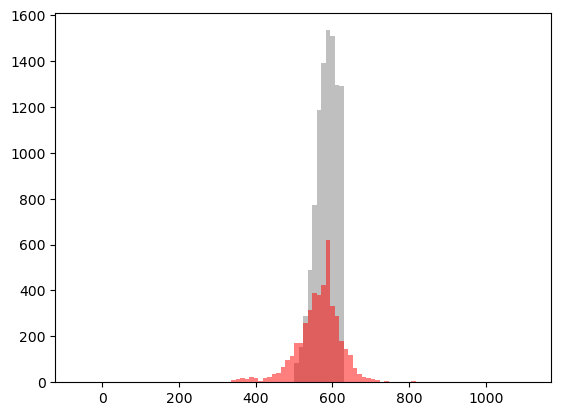

In [ ]:
import matplotlib.pyplot as plt
r = predictions[:, 2].cpu().detach().numpy()
s = data.iloc[:, 2].values
lo, hi = np.min([r.min(), s.min()]), np.max([r.max(), s.max()])
bins = np.linspace(lo, hi, 101)
plt.hist(r, bins=bins, alpha=0.5, label='Predictions', color='gray')
plt.hist(s, bins=bins, alpha=0.5, label='Data', color='red')